# Project - Twitter User Gender Classification 

#### Noa Schwartz- 203598842  , Danit Inzua- 318893120

## Q1. Text pre-processing and exploration

#### Import necessary libraries:

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# have to use latin1 even though it results in a lot of dead characters
import re
from collections import Counter
import itertools
from sets import Set
# function for encoding categories
from sklearn.preprocessing import LabelEncoder
# function to split the data for cross-validation
from sklearn.model_selection import train_test_split
from time import time

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: the sets module is deprecated


In [2]:
from IPython.display import HTML #let us treat data frame as it was table tag in html
# have to use latin1 even though it results in a lot of dead characters
twitterDataSet = pd.read_csv("c:\gender-classifier-DFE-791531.csv", encoding='latin1')
HTML(twitterDataSet.head().to_html(classes='table table-striped table-bordered table-hover')) #we can use css table's classs on the dataframe"

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815724691,False,finalized,3,10/26/2015 23:56,brand,1.0000,yes,1.0,1/28/2012 13:02,I write the blog Treats & Trinkets. I'm a nerd...,210,NaN,C744B8,TreatsTrinkets,NaN,https://pbs.twimg.com/profile_images/178806037...,0,FFFFFF,Zucchini Tacos with Mushrooms; lunch in the ri...,NaN,15928,10/26/2015 12:40,6.590000e+17,NaN,Eastern Time (US & Canada)
1,815722062,False,finalized,3,10/26/2015 22:21,brand,1.0000,yes,1.0,4/7/2010 21:19,A real person. Most followed Astrology on Twit...,942,NaN,0084B4,XSTROLOGY,NaN,https://pbs.twimg.com/profile_images/378800000...,0,FFFFFF,Zodiac Signs in The Bedroom https://t.co/U7M9V...,NaN,169830,10/26/2015 12:40,6.590000e+17,The Stars,Pacific Time (US & Canada)
2,815730655,False,finalized,3,10/27/2015 0:41,male,0.6565,yes,1.0,5/13/2014 22:57,Don't follow me. I tweet garbage.,147,NaN,A100B3,SethuIsShe,NaN,https://pbs.twimg.com/profile_images/656092017...,0,C0DEED,Zindzi Koki and Bongi must stop this nonsense....,NaN,23498,10/26/2015 13:20,6.590000e+17,Pretoria,NaN
3,815724867,False,finalized,3,10/26/2015 23:37,brand,1.0000,yes,1.0,10/15/2009 12:15,The New Republic is a mission-driven media org...,1016,NaN,FA743E,NewRepublic,NaN,https://pbs.twimg.com/profile_images/631195731...,0,FFFFFF,Zappos got rid of all its bosses (sort of). Is...,NaN,53431,10/26/2015 12:40,6.590000e+17,"Washington, DC",Eastern Time (US & Canada)
4,815723296,False,finalized,3,10/26/2015 22:33,brand,0.6556,yes,1.0,3/2/2012 23:52,"Farooq Wani,voracious reader of books,editor d...",2,NaN,0084B4,brighterkashmir,NaN,https://pbs.twimg.com/profile_images/491788576...,0,C0DEED,zahir-ud-Din An active member of the Muslim Co...,NaN,8509,10/26/2015 12:40,6.590000e+17,Kashmir,NaN


In [3]:
#clean a tweet
def cleanData(text):
    #print(text)
    #print("******************************")
    text = text.lower()

    # remove punctuation, spaces digits and "https"
    text = re.sub('\s\W',' ',text)
    text = re.sub('\W,\s',' ',text)
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub("\d+", "", text)
    text = re.sub('\s+',' ',text)
    text = re.sub('[!@#$_]', '', text)
    text = text.replace("https","")
    text = text.replace(",","")
    text = text.replace("[\w*"," ")

    stop_words = stopwords.words('english') + list(string.punctuation)
    stemmer = SnowballStemmer("english")

    twitAfterTokenize = word_tokenize(text) #text after tokenize (from full sentences to separated words)
    filteredTwit = [word for word in twitAfterTokenize if word not in stop_words]
    twitAfterStemming = [stemmer.stem(word) for word in filteredTwit] #stem each word in the text
    twitAfterStemmingStr = ' '.join(twitAfterStemming)
    return twitAfterStemmingStr

#get all the common terms and their frequency in a category
def getCommonTermsPerCat (gender):
    allTermsInCat = list(itertools.chain(*twitsPerGender[gender]))#make list of all terms (transfer list of lists to one list)
    termsCounter = Counter(allTermsInCat)
    return (termsCounter.most_common(30))

In [4]:
#update the corpus with the clean twits
twitterDataSet['text_norm'] = [cleanData(s) for s in twitterDataSet['text']]
#twitterDataSet['description_norm'] = [cleanData(s) for s in twitterDataSet['description']]


print("Class Distribution:")
print("***************************************************")
print(twitterDataSet.gender.value_counts())
print("")

#get the tweet foreach gender
twitsPerGender ={};
twitsPerGender['male'] = [];
twitsPerGender['female'] = [];
twitsPerGender['unknown'] = [];
twitsPerGender['brand'] = [];
for index, row in twitterDataSet.iterrows(): # iterate each row
    #twitsPerGender[row['gender']].append(row['text_norm']) #if we want that twit will save as string not list
    twitsPerGender[row['gender']].append(row['text_norm'].split())
#count the twits in each category
#print("Class Distribution:")
#print("***************************************************")
#for key, value in twitsPerGender.iteritems():
    #print('{}: {} twits'.format(key,len(value)))
commonWords = [];
##get the terms distribution
table_of_most_frequent = {};# array of tuples - term and requenchy
most_freq_byCat = {};
temp = {};
commTermsInAll = []
commSet = Set(commTermsInAll);
for gen in twitsPerGender:
    #print (gen)
    lst = getCommonTermsPerCat(gen);
    table_of_most_frequent[gen] = lst;
    most_freq_byCat[gen] = [];
    temp[gen] = [];

for gen in twitsPerGender:
    for commTerm, word_count in table_of_most_frequent[gen]:
        most_freq_byCat[gen].append(commTerm)

for gen in twitsPerGender:
    ##remove terms that apear in all categories as common
    for commTerm in most_freq_byCat[gen]:
        if(commTerm not in commSet):
            counter = 1
            for otherGen in twitsPerGender:
                if(otherGen != gen and commTerm in most_freq_byCat[otherGen]):
                    counter = counter +1
            if(counter == len(twitsPerGender)):
                commSet.add(commTerm)
                #print(commTerm)

#remove the terms that common in all categories
for gen in twitsPerGender:
    for i in table_of_most_frequent[gen]:
        if i[0] not in commSet:
            temp[gen].append(i)
    table_of_most_frequent[gen] = temp[gen];

Class Distribution:
***************************************************
female     6699
male       6193
brand      5942
unknown    1116
Name: gender, dtype: int64




Terms Frequency:
***************************************************
              brand        female          male                  unknown
0   (weather, 2279)   (want, 256)   (know, 202)           (weather, 402)
1     (updat, 1174)   (know, 235)   (good, 189)             (updat, 205)
2   (channel, 1173)    (got, 211)    (got, 189)           (channel, 203)
3        (amp, 191)    (amp, 203)  (think, 185)  (pushawardslizquen, 31)
4         (us, 168)   (best, 194)   (want, 179)         (forevermor, 31)
5       (year, 137)  (thing, 183)   (need, 171)               (year, 28)
6       (come, 129)   (need, 182)   (back, 161)   (everydayiloveyou, 28)
7       (best, 124)  (think, 177)   (come, 160)               (want, 26)
8        (via, 115)   (back, 176)   (year, 157)               (fuck, 25)
9       (week, 112)    (say, 175)   (best, 155)              (think, 25)
10     (check, 109)   (work, 175)   (fuck, 155)               (know, 25)
11      (game, 100)   (good, 170)  (would, 154)       

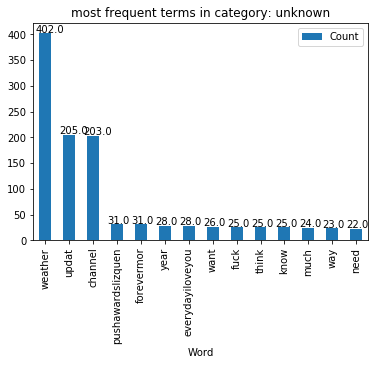

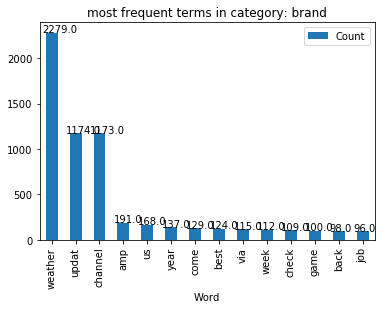

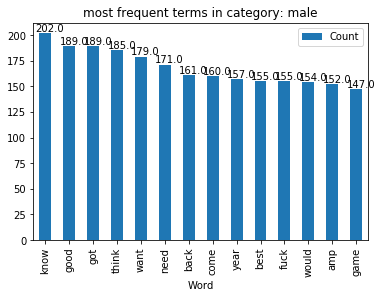

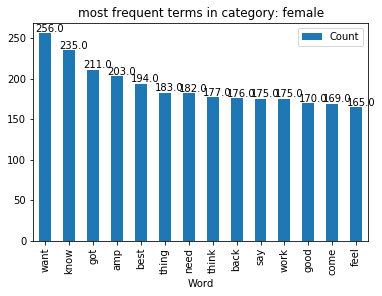

In [5]:
#plot the results
for gen in twitsPerGender:
    df3 = pd.DataFrame(table_of_most_frequent[gen], columns = ['Word', 'Count'])
    ax = df3.plot.bar(title ="most frequent terms in category: " + gen, x='Word',y='Count')
    x_offset = -0.4
    y_offset = 2
    for p in ax.patches:
        b = p.get_bbox()
        val = b.y1 + b.y0
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
    #print(gen)
    #print("**************************")
    #print(df3)
df2 = pd.DataFrame(table_of_most_frequent)
df2.transpose()
print("")
print("Terms Frequency:") #without terms that common apear in all category
print("***************************************************")
print (df2)
plt.show()

In [6]:
print("")
print("The terms that are common in all categories")
print("***************************************************")
print (commSet)


The terms that are common in all categories
***************************************************
Set([u'last', u'like', u'love', u'get', u'peopl', u'make', u'thank', u'new', u'one', u'see', u'follow', u'time', u'go', u'co', u'day', u'look'])


## Q2. Train a machine learning model to predict the gender of the tweet author

In [7]:
#remove all rows in dataset that have Nan value in "gender:confidence" column
gender_confidence = twitterDataSet['gender:confidence'][np.where(np.invert(np.isnan(twitterDataSet['gender:confidence'])))[0]]
twitterDataSet_confident = twitterDataSet[twitterDataSet['gender:confidence']==1]

textsAfterClean = twitterDataSet_confident['text_norm']
genders = twitterDataSet_confident['gender']

# split into train and test sets using cross validation
x_train, x_test, y_train, y_test = train_test_split(textsAfterClean, genders, test_size=0.2)

### function that train the given model and give us the accuracy score and the time the traininig took

In [8]:
#this function recieve: clf-the chosen classifier, x_train and x_test- BOW/TF-IDF matrix (from feature extraction)
#then train the model clf and return the results
def benchmark(clf, x_train, x_test):

    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

### function that make plot of comparison between machine learning methods

In [9]:
#function that receive the results of the training models and displays the comparison between them
def makePlot (results):
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()

### feature extraction

In [10]:
vectorizer = CountVectorizer()
BOW_train = vectorizer.fit_transform(x_train)
BOW_test = vectorizer.transform(x_test)

Tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
Tfidf_train = Tfidf_vectorizer.fit_transform(x_train)
Tfidf_test = Tfidf_vectorizer.transform(x_test)

### Results of the classify using Bag of words feature extraction:

SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.053s
test time:  0.001s
accuracy:   0.548
Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.065s
test time:  0.001s
accuracy:   0.571


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


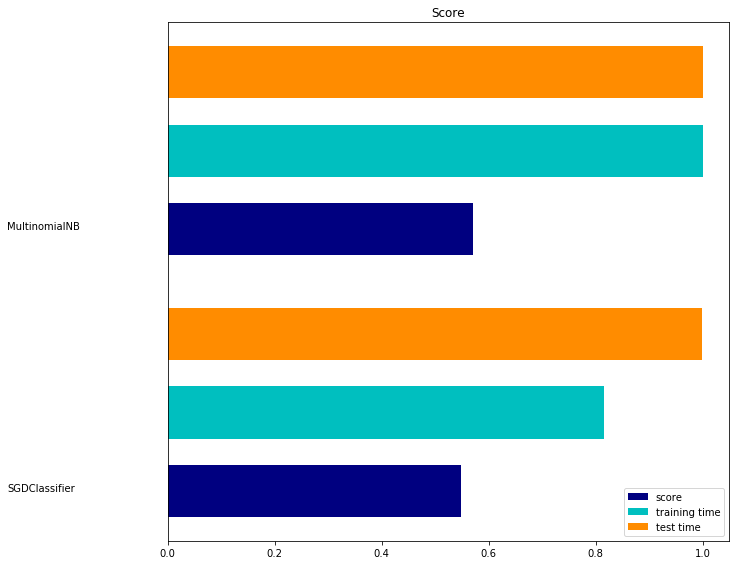

In [11]:
results_BOW = []
for clf, name in (
        (SGDClassifier(),"SVM"),
        (MultinomialNB(),"Naive Bayes")):
    print('=' * 80)
    print(name)
    results_BOW.append(benchmark(clf, BOW_train,BOW_test))
makePlot(results_BOW)

### Results of the classify using TF-IDF feature extraction:

SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.050s
test time:  0.000s
accuracy:   0.553
Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.058s
test time:  0.000s
accuracy:   0.535


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in divide


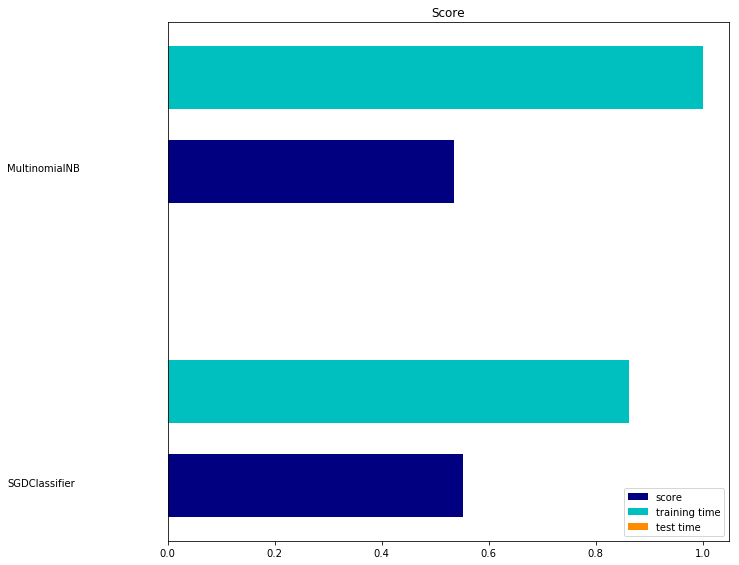

In [12]:
results_Tfidf = []
for clf, name in (
        (SGDClassifier(),"SVM"),
        (MultinomialNB(),"Naive Bayes")):
    print('=' * 80)
    print(name)
    results_Tfidf.append(benchmark(clf, Tfidf_train,Tfidf_test))
makePlot(results_Tfidf)

### Tune each model parameters to optimize the results using pipeline

#### find the best parameters for both the feature extraction-BOW and the classifier-Naive Bayes:

In [13]:
svmResults  = []
NBResults = []

nb_clf1 = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB())])
parameters_clf1 =  {
    'vect__max_df': (0.3,0.5,1.0),
    'clf__alpha': (0.01,1.0),
    'clf__fit_prior':(False,True)}
gs_clf1 = GridSearchCV(nb_clf1, parameters_clf1, n_jobs=1)
gs_clf1 = gs_clf1.fit(x_train,y_train)
print('Best score: ',gs_clf1.best_score_)
NBResults.append(gs_clf1.best_score_)
print('Best params: ',gs_clf1.best_params_)

('Best score: ', 0.54506283662477562)
('Best params: ', {'vect__max_df': 0.5, 'clf__fit_prior': True, 'clf__alpha': 1.0})


#### find the best parameters for both the feature extraction-Tf idf and the classifier-Naive Bayes:

In [ ]:
nb_clf2 = Pipeline([('vect', TfidfVectorizer()),('clf', MultinomialNB())])
parameters_clf2 =  {
    'vect__max_df': (0.3,0.5,1.0),
    'vect__sublinear_tf':(True, False),
    'clf__alpha': (0.01,1.0),
    'clf__fit_prior':(False,True)}
gs_clf2 = GridSearchCV(nb_clf2, parameters_clf2, n_jobs=1)
gs_clf2 = gs_clf2.fit(x_train,y_train)
NBResults.append(gs_clf2.best_score_)
print('Best score: ',gs_clf2.best_score_)
print('Best params: ',gs_clf2.best_params_)

('Best score: ', 0.53070017953321369)
('Best params: ', {'vect__max_df': 0.5, 'clf__fit_prior': False, 'vect__sublinear_tf': True, 'clf__alpha': 1.0})


#### find the best parameters for both the feature extraction-BOW and the classifier-SVM:

In [ ]:
svm_clf3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier()),
])
parameters_clf3 = {
    'vect__max_df': (0.3,0.5,1.0),
    'clf__alpha': (0.001,0.0001,0.00001,0.000001),
    'clf__penalty': ('elasticnet','none', 'l2','l1'),
    'clf__epsilon':(0.1,0.2)}
gs_clf3 = GridSearchCV(svm_clf3, parameters_clf3, n_jobs=1)
gs_clf3 = gs_clf3.fit(x_train,y_train)
svmResults.append(gs_clf3.best_score_);
print('Best score: ',gs_clf3.best_score_)
print('Best params: ',gs_clf3.best_params_)

#### find the best parameters for both the feature extraction-Tf idf and the classifier-SVM:

In [ ]:
svm_clf4 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier()),
])
parameters_clf4 = {
    'vect__max_df': (0.3,0.5,1.0),
    'vect__sublinear_tf':(True, False),
    'clf__alpha': (0.001,0.0001,0.00001,0.000001),
    'clf__penalty': ('elasticnet','none', 'l2','l1'),
    'clf__epsilon':(0.1,0.2)}
gs_clf4 = GridSearchCV(svm_clf4, parameters_clf4, n_jobs=1)
gs_clf4 = gs_clf4.fit(x_train,y_train)
svmResults.append(gs_clf4.best_score_);
print('Best score: ',gs_clf4.best_score_)
print('Best params: ',gs_clf4.best_params_)

### Use the best models selected in the previous steps for prediction on the test set and present the accuracy for each machine learning model

#### Results of  the model Naive Bayes (with the receive pipeline's parameters):

In [ ]:
#Naive Bayes best with Bag of word
#Best params:  {'vect__max_df': 0.5, 'clf__fit_prior': True, 'clf__alpha': 1.0}
count_vectorizer1 = CountVectorizer(max_df=0.5, stop_words='english')
count_train1 = count_vectorizer1.fit_transform(x_train)
count_test1 = count_vectorizer1.transform(x_test)
results1 = []
clf_nb=MultinomialNB(fit_prior=True,alpha=1.0)
print("Naive Bayes BOW")
results1.append(benchmark(clf_nb, count_train1,count_test1))

#### Results of  the model SVM (with the receive pipeline's parameters):

In [ ]:
#SVM best with Bag of word
#Best params: {'vect__max_df': 0.5, 'clf__penalty': 'l2', 'clf__epsilon': 0.1, 'clf__alpha': 0.001}
count_vectorizer1 = CountVectorizer(max_df=0.5, stop_words='english')
count_train2 = count_vectorizer1.fit_transform(x_train)
count_test2 = count_vectorizer1.transform(x_test)
results2 = []
clf_svm=SGDClassifier(penalty='l2', alpha=0.001, epsilon=0.1)
print("SVM BOW")
results2.append(benchmark(clf_svm, count_train2,count_test2))